In [21]:
import pandas as pd

df = pd.read_csv('^NSEBANK.csv')

In [22]:
df['ret'] = df['Open'].pct_change()
df['fwd_ret5'] = df['Open'].pct_change(periods=5)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ret,fwd_ret5
0,2023-06-27,43804.550781,44194.648438,43693.148438,44121.500000,44121.500000,137300,0.002054,0.004748
1,2023-06-28,44419.500000,44508.398438,44163.199219,44327.800781,44327.800781,243800,0.014038,0.011963
2,2023-06-30,44666.000000,44787.101563,44447.199219,44747.351563,44747.351563,191300,0.005549,0.018033
3,2023-07-03,44957.949219,45353.199219,44882.101563,45158.101563,45158.101563,228200,0.006536,0.030163
4,2023-07-04,45310.550781,45655.500000,45000.250000,45301.449219,45301.449219,463000,0.007843,0.036505


In [26]:
import numpy as np
import pandas as pd

n = 46                     # length of vector
rho = 0.1                 # desired correlation = cos(angle)
theta = np.arccos(rho)         # corresponding angle
fixed_data = df['fwd_ret5']
new_data = np.random.normal(2, 0.5, n)  # new random data

fixed_data.reset_index(drop=True, inplace=True)  # Reset index of fixed_data
new_data = pd.DataFrame(new_data, columns=['x2'])  # Convert new_data to a Series

X = pd.concat([fixed_data, new_data], axis=1)  # dataframe with fixed and new data
Xctr = X - X.mean()  # centered columns (mean 0)

Q, _ = np.linalg.qr(Xctr[['fwd_ret5']].values)  # QR-decomposition, just matrix Q
P = Q @ Q.T  # projection onto space defined by x1
x2o = (np.eye(n) - P) @ Xctr['x2'].values  # x2ctr made orthogonal to x1ctr
Xc2 = pd.concat([Xctr['fwd_ret5'], pd.Series(x2o, name='x2o')], axis=1)  # bind to dataframe
Y = Xc2.div(np.sqrt(np.sum(Xc2**2, axis=0)), axis=1)  # scale columns to length 1

x = Y['x2o'] + (1 / np.tan(theta)) * Y['fwd_ret5']  # final new vector

df_with_new_column = pd.concat([X, pd.Series(x, name='new_column')], axis=1)  # dataframe with new column added
print(df_with_new_column)
print(np.corrcoef(df_with_new_column['fwd_ret5'], df_with_new_column['new_column'])[0, 1])  # check correlation = rho


    fwd_ret5        x2  new_column
0   0.004748  1.828461   -0.059618
1   0.011963  2.702655    0.193575
2   0.018033  1.826424   -0.031244
3   0.030163  1.746109   -0.026651
4   0.036505  2.953060    0.315039
5   0.031165  2.988872    0.313140
6   0.014432  1.834771   -0.036819
7   0.010121  1.957795   -0.012785
8   0.000016  1.526550   -0.151940
9  -0.006898  2.234107    0.025221
10 -0.006577  3.395694    0.341476
11 -0.001137  2.489529    0.107153
12 -0.005705  1.444387   -0.186717
13 -0.000166  2.475774    0.105531
14  0.016819  2.793477    0.228821
15  0.016712  1.002989   -0.257816
16  0.015102  1.347859   -0.167633
17  0.026823  1.302100   -0.154543
18  0.026266  1.775108   -0.027258
19  0.008740  1.725095   -0.079007
20  0.006853  1.609687   -0.114467
21  0.013062  1.859155   -0.033176
22 -0.010921  1.924355   -0.067686
23 -0.012693  2.474792    0.077988
24 -0.008985  1.882621   -0.074808
25 -0.015250  2.812247    0.164093
26 -0.030744  1.776310   -0.151067
27 -0.017694  1.2352

In [27]:
df_with_new_column['new_column'].corr(df_with_new_column['fwd_ret5'])

0.10000000000000013

In [28]:
df_final = pd.concat([df, df_with_new_column], axis=1)


In [29]:
df_final.to_csv('banknifty_final.csv')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your data
data = pd.read_csv('df_final.csv')

# Split the data into an 80-20 ratio
train_data, x_data = train_test_split(data, train_size=0.7, shuffle=False)
validate_data, test_data = train_test_split(x_data, train_size=0.5, shuffle=False)

# Save the train and test data to separate CSV files
train_data.to_csv('trainbase_data.csv', index=False)
test_data.to_csv('testbase_data.csv', index=False)
validate_data.to_csv('validation_data.csv', index=False)

In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('validation_data.csv')

# Select the desired columns
selected_columns = df[['Open', 'ret', 'new_column']]

# Save the selected columns to a new CSV file
selected_columns.to_csv('validation_file.csv', index=False)

In [1]:
import numpy as np
import gym
import gymnasium
from gymnasium import spaces
from collections import deque
import pandas as pd

class TradingEnv(gym.Env):
    def __init__(self, env_config):
        super(TradingEnv, self).__init__()

        data = pd.read_csv(env_config["data_filepath"])
        self.historical_data = data['Open']
        self.returns = data['ret']
        self.sma = data['new_column']
        self.window_size = env_config["window_size"]
        self.unrealized_pnl_history = deque([0.0]*5, maxlen=5)

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(env_config["window_size"], 3), dtype=np.float32)
        
        self.max_episode_steps = 20
        np.random.seed(123)

        self.reset()


    def step(self, action):
        current_price = self.historical_data[self.current_step]
        current_ret = 0
        unrealized_pnl = 0
        if action == 0:  # Buy
            if self.position == 0:
                self.position = 1
                self.buy_price = current_price
                #reward = 0
            elif self.position == -1:
                r = (self.sell_price - current_price)/self.sell_price
                current_ret = np.log(1 + r)
                self.position = 0
            else:
                unrealized_pnl = np.log(current_price/self.buy_price)
        elif action == 1:  # Sell
            if self.position == 0:
                self.position = -1
                self.sell_price = current_price
                #reward = 0
            elif self.position == 1:
                current_ret = np.log(current_price/self.buy_price)
                self.position = 0
            else:
                r = (self.sell_price - current_price)/self.sell_price
                unrealized_pnl = np.log(1 + r)
        else:  # Hold
            if self.position == 1:
                unrealized_pnl = np.log(current_price/self.buy_price)
            elif self.position == -1:
                r = (self.sell_price - current_price)/self.sell_price
                unrealized_pnl = np.log(1 + r)
            
            #reward = unrealized_pnl
        #reward = self.previous_reward
        reward = current_ret
        #if current_ret != 0 :
            #self.cumulative_return *= (1 + current_ret)
            #reward = self.cumulative_return - 1
            #self.previous_reward = reward
        
        self.unrealized_pnl_history.append(unrealized_pnl)
        unrealized_pnl_array = np.array(self.unrealized_pnl_history).reshape(-1, 1)
        new_returns = self.returns.iloc[self.current_step-self.window_size + 1:self.current_step + 1].fillna(0).values
        new_sma = self.sma.iloc[self.current_step-self.window_size + 1:self.current_step + 1].fillna(0).values
        temp_state = np.array([new_returns, new_sma]).T
        self.state = np.concatenate([temp_state, unrealized_pnl_array], axis=1)
        self.current_step += 1
        
        done = False
        if self.current_step >= len(self.historical_data) - 1:
            done = True
            #print("End of episode. State:", self.state)

        return np.array(self.state), reward, done, {}


    def reset(self):
        self.current_step = self.window_size
        self.position = 0
        self.buy_price = 0
        self.sell_price = 0
        #self.cumulative_returns = 0
        #self.cumulative_return = 1.0
        #self.previous_reward = 0.0
        self.unrealized_pnl_history = deque([0.0]*5, maxlen=5)
        unrealized_pnl_array = np.array(self.unrealized_pnl_history).reshape(-1, 1)
        self.current_step += np.random.randint(0, len(self.returns) - self.window_size - self.max_episode_steps )
        initial_returns = self.returns.iloc[self.current_step - self.window_size + 1:self.current_step + 1].fillna(0).values
        initial_sma = self.sma.iloc[self.current_step - self.window_size + 1:self.current_step + 1].fillna(0).values
        temp_state = np.array([initial_returns, initial_sma]).T
        self.state = np.concatenate([temp_state, unrealized_pnl_array], axis=1)
        return np.array(self.state)
    

In [2]:
import ray

ray.shutdown()
ray.init()

2023-09-20 03:00:16,446	INFO worker.py:1636 -- Started a local Ray instance.


Python version:,3.9.6
Ray version:,2.5.0


In [3]:
from gymnasium.wrappers import EnvCompatibility
from ray.tune.registry import register_env

def create_compatible_trading_env(env_config):
    env = TradingEnv(env_config)
    return EnvCompatibility(env)

register_env("wrapped_trading_env", create_compatible_trading_env)

In [4]:
import os

# Get the current working directory
cwd = os.getcwd()

# Construct the absolute paths of the data files
train_data_path = os.path.join(cwd, 'train_file.csv')
validation_data_path = os.path.join(cwd, 'validation_file.csv')

In [5]:
from ray.tune import Stopper

class EarlyStoppingStopper(Stopper):
    def __init__(self, patience, eval_patience, min_iterations, reward_weight=0.999, length_weight=0.001):
        self.patience = patience
        self.eval_patience = eval_patience
        self.reward_weight = reward_weight
        self.length_weight = length_weight
        self.min_iterations = min_iterations
        self.best_trial = None
        self.best_train_score = -float('inf')
        self.best_eval_score = -float('inf')
        self.strikes = 0
        self.eval_strikes = 0

    def __call__(self, trial_id, result):

        if result['training_iteration'] < self.min_iterations:
            return False

        # Calculate a score that is a weighted sum of the mean reward and the episode length
        train_score =  (result['episode_reward_mean'] )/ (result['episode_len_mean'])
        #eval_score = result['evaluation/episode_reward_mean'] 

        # If this is the best trial so far in terms of training score, update the best score and reset the strike counter
        if self.best_trial is None or train_score > self.best_train_score:
            self.best_trial = trial_id
            self.best_train_score = train_score
            self.strikes = 0

        # If this trial's training score is less than the best seen so far, increment the strike counter
        elif trial_id == self.best_trial:
            self.strikes += 1

        # If the evaluation score is improving, reset the evaluation strike counter
        if 'evaluation/episode_reward_mean' in result and (self.best_trial is None or ((result['evaluation/episode_reward_mean']) / (result['evaluation/episode_len_mean'])) > self.best_eval_reward):
            self.best_eval_reward = ((result['evaluation/episode_reward_mean']) / (result['evaluation/episode_len_mean']))
            self.eval_strikes = 0

        # If this trial's evaluation score is less than the best seen so far, increment the evaluation strike counter
        elif 'evaluation/episode_reward_mean' in result and trial_id == self.best_trial:
            self.eval_strikes += 1

        # Stop if we've had `patience` iterations without improvement in training score
        # or if we've had `eval_patience` iterations without improvement in evaluation score
        return self.strikes >= self.patience or self.eval_strikes >= self.eval_patience

    def stop_all(self):
        return self.strikes >= self.patience or self.eval_strikes >= self.eval_patience


In [6]:
#import ray
from ray.tune.schedulers import PopulationBasedTraining
from ray import tune
from ray.rllib.algorithms.ppo import PPO

# Define a PBT scheduler
pbt = PopulationBasedTraining(
    time_attr="time_total_s",
    metric="episode_reward_mean",
    mode="max",
    perturbation_interval=10.0, # This defines how frequently (in seconds) to perturb hyperparameters.
    hyperparam_mutations={
        "lr": tune.loguniform(1e-4, 1e-3),
        "gamma": tune.uniform(0.95, 0.99),
        "clip_param": tune.uniform(0.1, 0.3),
        "kl_coeff" : tune.uniform(0.2, 1.5)
    }
)

# Define a configuration
config = {
    "env": "wrapped_trading_env",
    #"monitor": False,
    #"checkpoint_freq": 10,  # Set the desired checkpoint frequency
    #"checkpoint_at_end": True,  # Uncomment this line if you want to checkpoint at the end
    "env_config": {
        "data_filepath": train_data_path,
        "window_size": 5,
        #"max_episodes_steps": 60
    },
    "evaluation_interval": 1,
    "evaluation_duration": 2,
    "evaluation_parallel_to_training": True,
    "evaluation_config": {
        "env": "wrapped_trading_env",
        "env_config": {
        "data_filepath": validation_data_path,  # replace with your validation data
        "window_size": 5,
            #"max_episode_steps": 20  # replace with the maximum number of steps for your validation episodes
        },
        "explore": False,
    },
    "batch_mode": "truncate_episodes",
    "rollout_fragment_length": 'auto',
    "evaluation_num_workers": 1,
    "always_attach_evaluation_results": True,
    "num_workers": 3,
    "num_cpus_per_worker": 1,
    "framework" : 'torch',
    "num_gpus": 0,
    "shuffle_sequences": False,
    "vf_loss_coeff": 0, 
    "lr": 0.0003,
    "gamma": 0.99,
    "clip_param": 0.2,
    "kl_coeff": 0.5,
    #"kl_coeff" : tune.uniform(0.1, 2.0),
    "num_sgd_iter" : tune.randint(25, 50),
    "sgd_minibatch_size" : tune.sample_from(lambda _: np.random.randint(2, 10)),
    "train_batch_size": tune.sample_from(lambda _: np.random.randint(15, 30)),
    #"train_bath_size": 32,
    "model":{
        "fcnet_hiddens": [64, 32],
        "fcnet_activation": "relu",
        "use_lstm": False,    
    },
    "log_level": "WARNING"
}
stopper = EarlyStoppingStopper(patience=1000, eval_patience=1000, min_iterations=5000)

# Run the Tune experiment
analysis = tune.run(
    PPO,
    #resources_per_trial={"cpu": 1, "gpu": 0},
    name="PPO_PBT_Trading",
    #reuse_actors=True,
    scheduler=pbt,
    #stop={
    #    #"evaluation/episode_reward_mean": 0.02,
    #    "episode_reward_mean": 0.15,
    #    "time_total_s": 1000  # Stop after 2 hours
    #    #"timesteps_total": 50000  # Or after 10,000 timesteps are trained
    #},
    stop = stopper,
    config=config,
    checkpoint_at_end=True,
    checkpoint_freq=10,
    num_samples=2,
    verbose=1
    #local_dir='/home/himanshu/ray_results/'
)


(PPO pid=24675) 2023-09-19 19:27:27,923	WARNING algorithm_config.py:643 -- Cannot create PPOConfig from given `config_dict`! Property __stdout_file__ not supported.
(RolloutWorker pid=24676) 2023-09-19 19:27:29,856	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(PPO pid=24675) 2023-09-19 19:27:31,602	WARNING util.py:68 -- Install gputil for GPU system monitoring.
(PPO pid=24687) 2023-09-19 19:27:46,245	WARNING algorithm_config.py:643 -- Cannot create PPOConfig from given `config_dict`! Property __stdout_file__ not supported.
(RolloutWorker pid=24679) 2023-09-19 19:27:46,245	WARNING algorithm_config.py:643 -- Cannot create PPOConfig from given `config_dict`! Property __stdout_file__ not supported.
(RolloutWorker pid=24688) 2023-09-19 19:27:48,138	WARNING env.py:155 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your en

In [7]:
# Get a dataframe for all the trials
df = analysis.results_df

# Get the trial with the highest mean reward
best_trial = analysis.get_best_trial("episode_reward_mean", "max", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final reward:", best_trial.last_result["episode_reward_mean"])

# Get the model from the best trial
#best_trained_model = PPO(
#    config=best_trial.config,
#    env="wrapped_trading_env",
#)
# Load the weights from the best trial
#best_trained_model.set_weights(best_trial.last_result["weights"])

Best trial config: {'env': 'wrapped_trading_env', 'env_config': {'data_filepath': '/Users/himanshuagrawal/rllib_project/train_file.csv', 'window_size': 5}, 'evaluation_interval': 1, 'evaluation_duration': 2, 'evaluation_parallel_to_training': True, 'evaluation_config': {'env': 'wrapped_trading_env', 'env_config': {'data_filepath': '/Users/himanshuagrawal/rllib_project/validation_file.csv', 'window_size': 5}, 'explore': False}, 'batch_mode': 'truncate_episodes', 'rollout_fragment_length': 'auto', 'evaluation_num_workers': 1, 'always_attach_evaluation_results': True, 'num_workers': 3, 'num_cpus_per_worker': 1, 'framework': 'torch', 'num_gpus': 0, 'shuffle_sequences': False, 'vf_loss_coeff': 0, 'lr': 0.00011030325691881245, 'gamma': 0.9323024727685087, 'clip_param': 0.07510086140256599, 'kl_coeff': 0.6572094397695664, 'num_sgd_iter': 43, 'sgd_minibatch_size': 8, 'train_batch_size': 29, 'model': {'fcnet_hiddens': [64, 32], 'fcnet_activation': 'relu', 'use_lstm': False}, 'log_level': 'WARNI

In [8]:
total_iterations = df['training_iteration'].max()
print(total_iterations)

6120


In [9]:
print(df['evaluation/episode_reward_mean'])

trial_id
76be2_00000    0.021723
76be2_00001   -0.019431
Name: evaluation/episode_reward_mean, dtype: float64


In [ ]:
import ray

best_trial_evaluation_results = best_trial.last_result["evaluation"]
print(best_trial_evaluation_results["episode_reward_mean"])

In [10]:
best_checkpoint = analysis.get_best_checkpoint(best_trial, metric="episode_reward_mean", mode="max")

In [11]:
print(best_checkpoint)

Checkpoint(local_path=/Users/himanshuagrawal/ray_results/PPO_PBT_Trading/PPO_wrapped_trading_env_76be2_00000_0_num_sgd_iter=43_2023-09-19_19-27-25/checkpoint_003580)


In [ ]:
ray.shutdown()
ray.init()

In [ ]:
from gymnasium.wrappers import EnvCompatibility
from ray.tune.registry import register_env

def create_compatible_trading_env(env_config):
    env = TradingEnv(env_config)
    return EnvCompatibility(env)

register_env("testing_trading_env", create_compatible_trading_env)

In [36]:


env_config = {
    "data_filepath": "testbase_data.csv",
    "window_size": 5,
}
env = TradingEnv(env_config)

best_trial = analysis.get_best_trial("episode_reward_mean", "max", "last")

best_checkpoint = analysis.get_best_checkpoint(best_trial, metric="episode_reward_mean", mode="max")
# Create a new trainer with the configuration of the best trial
best_trainer = PPO(env="wrapped_trading_env", config=best_trial.config)

# Restore the trainer state from the best checkpoint
best_trainer.restore(best_checkpoint)

num_episodes = 50
rewards = []
results = []

# Now you can use this trainer to compute actions in your testing loop
for i in range(num_episodes):
    episode_reward = 0
    done = False
    obs = env.reset()
    actions = []
    states = [obs]
    episode_rewards = []
    
    while not done:
        #action = best_trainer.compute_single_action(obs )
        # Initialize LSTM state
        state = best_trainer.get_policy().get_initial_state()

        # Use the state when computing actions
        action, state_out, _ = best_trainer.compute_single_action(obs, state=state, full_fetch=True)

        obs, reward, done, _ = env.step(action)
        
        actions.append(action)
        states.append(obs)
        episode_rewards.append(reward)
        
        episode_reward += reward

    rewards.append(episode_reward)
    results.append({
        'episode': i,
        'reward': episode_reward,
        'actions': actions,
        'states': states,
        'episode_rewards': episode_rewards
    })

# Now results is a list of dictionaries containing the actions, states, 
# rewards for each step in each episode, and the total reward for each episode
# This information can be used for further analysis

# If you want to get the complete action, reward and state values for the best performing test run, 
# You can use the following line of code:
best_episode = max(results, key=lambda x: x['reward'])

print(f"Best episode reward: {best_episode['reward']}")
print(f"Actions in best episode: {best_episode['actions']}")
print(f"States in best episode: {best_episode['states']}")
print(f"Rewards in best episode: {best_episode['episode_rewards']}")


2023-09-20 02:07:42,136	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='wrapped_trading_env', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('wrapped_trading_env').build()` instead. This will raise an error in the future!
/Users/himanshuagrawal/rllib_project/rllib_env/lib/python3.9/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/Users/himanshuagrawal/rllib_project/rllib_env/lib/python3.9/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecat

Best episode reward: 0.061915276537716876
Actions in best episode: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 2, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1]
States in best episode: [array([[ 3.12788668e-03,  4.17976366e-02,  0.00000000e+00],
       [-5.39665179e-03,  4.77476788e-02,  0.00000000e+00],
       [-6.37432049e-03, -2.00942516e-02,  0.00000000e+00],
       [-8.35535483e-04,  1.26973128e-02,  0.00000000e+00],
       [ 6.52200869e-05, -2.34443429e-02,  0.00000000e+00]]), array([[ 3.12788668e-03,  4.17976366e-02,  0.00000000e+00],
       [-5.39665179e-03,  4.77476788e-02,  0.00000000e+00],
       [-6.37432049e-03, -2.00942516e-02,  0.00000000e+00],
       [-8.35535483e-04,  1.26973128e-02,  0.00000000e+00],
       [ 6.52200869e-05, -2.34443429e-02,  0.00000000e+00]]), array([[-5.39665179e-03,  4.77476788e-02,  0.00000000e+00],
       [-6.37432049e-03, -2.00942516e-02,  0.00000000e+00],
       [-8.35535483e-04,  1.26973128e-02,  0.00000000e+00],
       [ 6.52200869e-05, -2.34

In [14]:
print(best_trainer.get_policy().model.state_dict().keys())

odict_keys(['flatten.0._hidden_layers.0._model.0.weight', 'flatten.0._hidden_layers.0._model.0.bias', 'flatten.0._hidden_layers.1._model.0.weight', 'flatten.0._hidden_layers.1._model.0.bias', 'flatten.0._value_branch_separate.0._model.0.weight', 'flatten.0._value_branch_separate.0._model.0.bias', 'flatten.0._value_branch_separate.1._model.0.weight', 'flatten.0._value_branch_separate.1._model.0.bias', 'flatten.0._value_branch._model.0.weight', 'flatten.0._value_branch._model.0.bias', 'flatten_0._hidden_layers.0._model.0.weight', 'flatten_0._hidden_layers.0._model.0.bias', 'flatten_0._hidden_layers.1._model.0.weight', 'flatten_0._hidden_layers.1._model.0.bias', 'flatten_0._value_branch_separate.0._model.0.weight', 'flatten_0._value_branch_separate.0._model.0.bias', 'flatten_0._value_branch_separate.1._model.0.weight', 'flatten_0._value_branch_separate.1._model.0.bias', 'flatten_0._value_branch._model.0.weight', 'flatten_0._value_branch._model.0.bias', 'post_fc_stack._value_branch._model.

In [8]:
mean_reward = sum(rewards)/len(rewards)

In [9]:
print(mean_reward)

0.03155970240034727


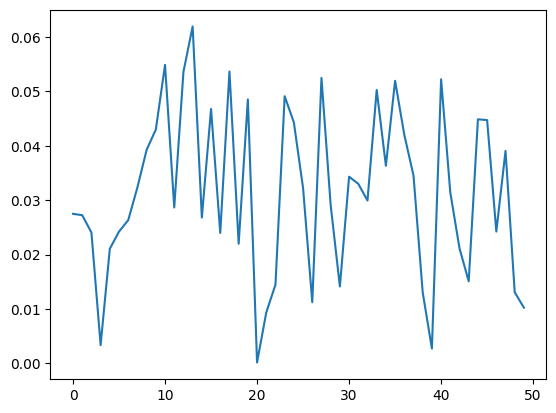

In [39]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure()
# Plot the data
plt.plot(rewards)
# Display the plot
plt.show()

ray.shutdown()

In [ ]:
import ray
print(ray.__version__)

In [12]:
import json
# Extract the checkpoint path from the best_checkpoint object
#Checkpoint(local_path=/Users/himanshuagrawal/ray_results/PPO_PBT_Trading/PPO_wrapped_trading_env_76be2_00000_0_num_sgd_iter=43_2023-09-19_19-27-25/checkpoint_003580)
checkpoint_path_to_save = '/Users/himanshuagrawal/ray_results/PPO_PBT_Trading/PPO_wrapped_trading_env_76be2_00000_0_num_sgd_iter=43_2023-09-19_19-27-25/checkpoint_003580'

# Save the checkpoint path and best trial config
with open('model_info1.json', 'w') as f:
    json.dump({
        'checkpoint_path': checkpoint_path_to_save,
        'best_trial_config': best_trial.config
    }, f)

In [7]:
import json
from ray.rllib.algorithms.ppo import PPO

with open('model_info1.json', 'r') as f:
        model_info = json.load(f)

env_config = {
    "data_filepath": "testbase_data.csv",
    "window_size": 5,
}
env = TradingEnv(env_config)

checkpoint_path = model_info['checkpoint_path']
best_trial_config = model_info['best_trial_config']
        #best_trial_config["env_config"] = {"disable_env_checking": True}
trainer = PPO(env="wrapped_trading_env", config=best_trial_config)
trainer.restore(checkpoint_path)

num_episodes = 50
rewards = []
results = []

# Now you can use this trainer to compute actions in your testing loop
for i in range(num_episodes):
    episode_reward = 0
    done = False
    obs = env.reset()
    actions = []
    states = [obs]
    episode_rewards = []
    
    while not done:
        #action = best_trainer.compute_single_action(obs )
        # Initialize LSTM state
        state = trainer.get_policy().get_initial_state()

        # Use the state when computing actions
        action, state_out, _ = trainer.compute_single_action(obs, state=state, full_fetch=True)

        obs, reward, done, _ = env.step(action)
        
        actions.append(action)
        states.append(obs)
        episode_rewards.append(reward)
        
        episode_reward += reward

    rewards.append(episode_reward)
    results.append({
        'episode': i,
        'reward': episode_reward,
        'actions': actions,
        'states': states,
        'episode_rewards': episode_rewards
    })


2023-09-20 03:02:02,975	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='wrapped_trading_env', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('wrapped_trading_env').build()` instead. This will raise an error in the future!
/Users/himanshuagrawal/rllib_project/rllib_env/lib/python3.9/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/Users/himanshuagrawal/rllib_project/rllib_env/lib/python3.9/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecat

In [11]:
import json
import numpy as np

def default_serialize(o):
    if isinstance(o, np.integer):
        return int(o)
    elif isinstance(o, np.floating):
        return float(o)
    elif isinstance(o, np.ndarray):
        return o.tolist()
    else:
        raise TypeError(f"Object of type '{type(o).__name__}' is not JSON serializable")

with open('results.json', 'w') as f:
    json.dump(results, f, default=default_serialize)